# Chapter 3: Classification

### MNIST
MNIST Dataset: 70,000 small images of digits handwritten by high school students and employees of the US Census Bureau.

In [14]:
# Fetch MNIST dataset:
from sklearn.datasets import fetch_mldata

mnist = fetch_mldata('MNIST original', transpose_data=True, data_home='files')
mnist

In [19]:
X, y = mnist["data"], mnist["target"]
X.shape, y.shape

((70000, 784), (70000,))

5.0

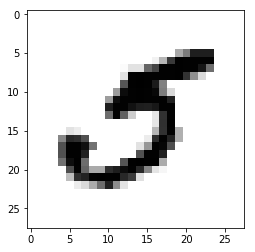

In [23]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

some_digit = X[36000]
some_digit_image = some_digit.reshape(28,28)
plt.imshow(some_digit_image, cmap = matplotlib.cm.binary, interpolation='nearest')
y[36000]

In [25]:
# Create Train and test sets
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

In [27]:
# Shuffle the datasets
import numpy as np

shuffle_ix = np.random.permutation(60000)
X_train, y_train = X_train[shuffle_ix], y_train[shuffle_ix]

### Training a Binary Classifier

In [28]:
# Binary classifier: 5-detector
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

In [35]:
# Create SGD Classifier (Stochastic Gradient Descent) and train it on the whole dataset
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

/anaconda3/envs/PythonData/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', max_iter=None, n_iter=None,
       n_jobs=1, penalty='l2', power_t=0.5, random_state=42, shuffle=True,
       tol=None, verbose=0, warm_start=False)

In [36]:
sgd_clf.predict([some_digit])

array([ True])

### Performance Measures

In [45]:
# Measuring Accuracy using Cross-Validation
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3, random_state=42)

for train_ix, test_ix in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_ix]
    y_train_folds = (y_train_5[train_ix])
    X_test_fold = X_train[test_ix]
    y_test_fold = (y_train_5[test_ix])
    
    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct / len(y_pred))

0.95465
0.966
0.96335


In [46]:
from sklearn.model_selection import cross_val_score

cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.95465, 0.966  , 0.96335])

In [47]:
from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        pass
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)

In [48]:
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.91075, 0.9099 , 0.9083 ])

### Confusion Matrix
A much better way to evaluate the performance of a classifier is to look at the confusion matrix.

In [53]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

In [54]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_train_5, y_train_pred)

array([[53954,   625],
       [ 1695,  3726]])

[[true negatives (53954), false positives (625)], 53954 were correctly classified as non-5s, 625 were wrongly classifed as 5s.

[false negatives (1695), true positives (3726)]] 1695 were wrongly classified as non-5s, 3726 were correctly classified as 5s.

In [56]:
confusion_matrix(y_train_5, y_train_5)

array([[54579,     0],
       [    0,  5421]])

### Precision and Recall
Precision = TP / (TP + FP)

Recall (Sensitivity or true positive rate (TPR)): this is the ratio of positive instances that are correctly detected by the classifier

recall = TP / (TP + FN)

In [62]:
from sklearn.metrics import precision_score, recall_score

precision_score(y_train_5, y_train_pred), recall_score(y_train_5, y_train_pred)

(0.8563548609515054, 0.6873270614277809)

When it claims an image represents a 5, it is correct only 85% of the time.
Moreover, it only detects 68% of the 5s.

In [63]:
# F1 score: combine the precision and recall (the harmonic mean of precision and recall)
# F1 = TP / (TP + ((FN + FP)/2))
from sklearn.metrics import f1_score

f1_score(y_train_5, y_train_pred)

0.7625869832173557

In [64]:
# Return a score for each instance, and then make predictions based on those scores using any threshold
y_scores = sgd_clf.decision_function([some_digit])
y_scores

array([46921.42611093])

In [66]:
# The SGDClassifier using a threshold equal to 0
threshold = 0
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([ True])

In [67]:
threshold = 200000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False])

In [69]:
# Get scores of all instances in the training set using the cross_val_predict()
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method="decision_function")
y_scores

array([ -268230.25877681,  -851422.36421016, -1066095.96955148, ...,
        -642280.8066983 ,  -421032.54178155,  -543060.26331251])

In [70]:
# Compute precision and recall for all possible threshold using the precision_recall_curve
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

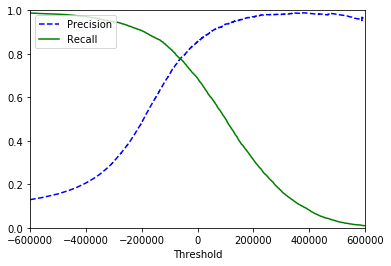

In [79]:
# Plot precision and recall as functions of the threshold value
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    plt.xlabel("Threshold")
    plt.legend(loc="upper left")
    plt.ylim([0, 1])
    plt.xlim([-600000, 600000])
    
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()